In [1]:
!pip3 install -q tensorflow_decision_forests

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-gpu 2.4.1 requires gast==0.3.3, but you have gast 0.4.0 which is incompatible.
tensorflow-gpu 2.4.1 requires grpcio~=1.32.0, but you have grpcio 1.40.0 which is incompatible.
tensorflow-gpu 2.4.1 requires h5py~=2.10.0, but you have h5py 3.1.0 which is incompatible.
tensorflow-gpu 2.4.1 requires tensorflow-estimator<2.5.0,>=2.4.0, but you have tensorflow-estimator 2.6.0 which is incompatible.


In [2]:
!pip install pytorch-tabnet

In [3]:
!pip install --upgrade git+https://github.com/tusharsarkar3/XBNet.git

  Cloning https://github.com/tusharsarkar3/XBNet.git to /tmp/pip-req-build-3imsgo3t
  Running command git clone -q https://github.com/tusharsarkar3/XBNet.git /tmp/pip-req-build-3imsgo3t
  Created wheel for XBNet: filename=XBNet-1.3.1-py3-none-any.whl size=8102 sha256=ddda276aa4e082b844bcf9fc68fc498e6d11aed28f4fd6d2f6ff8d30fe1931b6
  Stored in directory: /tmp/pip-ephem-wheel-cache-ogcedi46/wheels/23/c6/c1/0ee5a35c7a28c4dd8db05ce1407d1ccb0cfb036216e0c2ff92
Successfully built XBNet


<h1 style="color:blue">Librerías</h1>

In [4]:
### General ###
import os
import math
import random
import warnings
import numpy as np
import pandas as pd

### Visualization ###
import matplotlib as mpl
from colorama import Fore
import matplotlib.pyplot as plt
from IPython.display import IFrame

### Machine Learning Tools ###
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, train_test_split

### Tensorflow Ecosystem ###
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_decision_forests as tfdf
from tensorflow.keras.layers import IntegerLookup
from tensorflow.keras.layers import Normalization
from tensorflow.keras.layers import StringLookup

In [5]:
np.random.seed(42)
tf.random.set_seed(42)
plt.style.use("bmh")
warnings.filterwarnings("ignore")
mpl.rcParams["agg.path.chunksize"] = 10000
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [6]:
b_ = Fore.BLUE
c_ = Fore.CYAN
g_ = Fore.GREEN
m_ = Fore.MAGENTA
r_ = Fore.RED
y_ = Fore.YELLOW

<h1 style="color:blue">Neural Network + GMB</h1>

In [7]:
df = pd.read_csv("../input/covid19-in-india/covid_19_india.csv")

# Replaces numerical NaN (NNs are bad with NaNs)
for col in df.columns:
  if df[col].dtype not in [str, object]:
    df[col] = df[col].fillna(0)

df.Date = pd.to_datetime(df.Date, format = "%Y-%m-%d")
df.set_index("Date", drop = False, inplace = True)

In [8]:
df.Date.max()

Timestamp('2021-08-11 00:00:00')

In [9]:
df.Date.min()

Timestamp('2020-01-30 00:00:00')

In [10]:
df.dtypes

Sno                                  int64
Date                        datetime64[ns]
Time                                object
State/UnionTerritory                object
ConfirmedIndianNational             object
ConfirmedForeignNational            object
Cured                                int64
Deaths                               int64
Confirmed                            int64
dtype: object

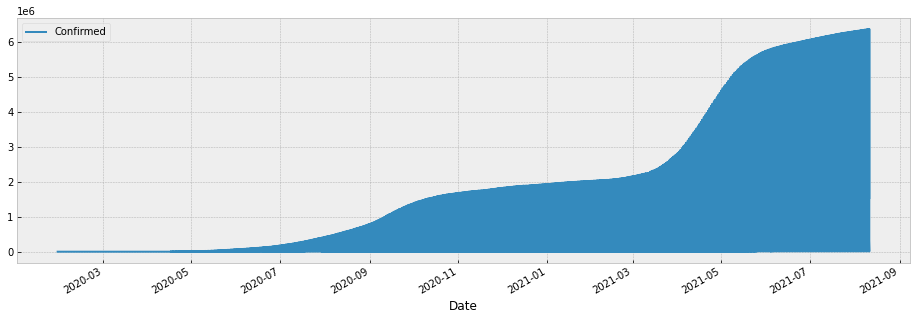

In [11]:
df[["Confirmed"]].plot(figsize = (16, 5));

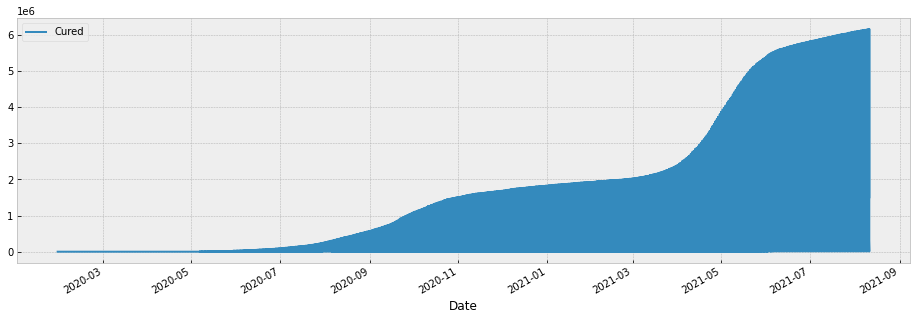

In [12]:
df[["Cured"]].plot(figsize = (16, 5));

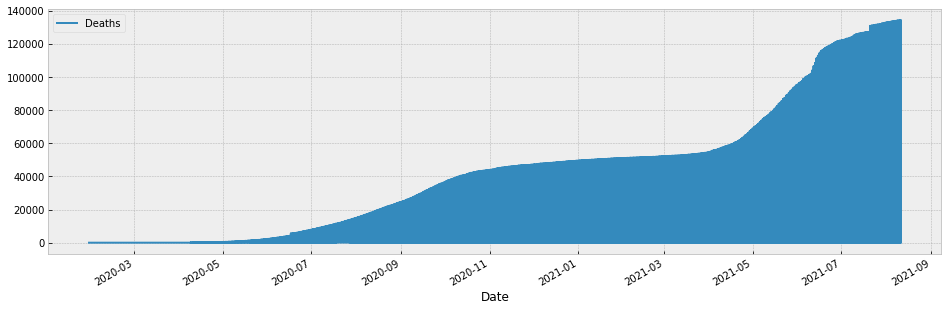

In [13]:
df[["Deaths"]].plot(figsize = (16, 5));

In [14]:
train = df[df.Date < "2021-07-11"]
test = df[df.Date >= "2021-07-11"]

In [15]:
def split_dataset(dataset, val_ratio = 0.20):
  """
  Splits a panda dataframe in two.
  """
  val_indices = np.random.rand(len(dataset)) < val_ratio
  return dataset[~val_indices], dataset[val_indices]

In [16]:
train_ds_pd, val_ds_pd = split_dataset(train)
print("{}{}{} examples in training, {}{}{} examples for validation.".format(
    r_,len(train_ds_pd), b_,r_,len(val_ds_pd),b_))

13521 examples in training, 3437 examples for validation.


In [17]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
    train_ds_pd.drop("Date", axis = 1), 
    label = "Confirmed",
    task = tfdf.keras.Task.REGRESSION
)

val_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
    val_ds_pd.drop("Date", axis = 1), 
    label = "Confirmed",
    task = tfdf.keras.Task.REGRESSION
)

test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
    test.drop("Date", axis = 1), 
    label = "Confirmed",
    task = tfdf.keras.Task.REGRESSION
)

In [18]:
def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode = "binary")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature

<h2 style="color:red">Modelling</h2>


Red Neuronal con tres entradas

In [19]:
input_1 = tf.keras.Input(shape = (1, ), name = "State/UnionTerritory", dtype = "string")
input_2 = tf.keras.Input(shape = (1, ), name = "Cured", dtype = "float")
input_3 = tf.keras.Input(shape = (1, ), name = "Deaths", dtype = "float")

nn_raw_inputs = [input_1, input_2, input_3]

input_1_encoded = encode_categorical_feature(input_1, "State/UnionTerritory", train_ds, True)
input_2_encoded = encode_numerical_feature(input_2, "Cured", train_ds)
input_3_encoded = encode_numerical_feature(input_3, "Deaths", train_ds)

nn_processed_inputs = [input_1_encoded, input_2_encoded, input_3_encoded]

In [20]:
y = tf.keras.layers.Concatenate()(nn_processed_inputs)
y = tf.keras.layers.Dense(32, activation = tf.nn.relu6)(y)
y = tf.keras.layers.Dropout(0.5)(y)
y = tf.keras.layers.Dense(16, activation = tf.nn.relu)(y)
y = tf.keras.layers.Dropout(0.5)(y)
last_layer = tf.keras.layers.Dense(4, activation = tf.nn.relu, name = "last")(y)
last_layer = tf.keras.layers.Dropout(0.3)(last_layer)

regression_output = tf.keras.layers.Dense(1, activation = "linear")(y)

nn_model = tf.keras.models.Model(nn_raw_inputs, regression_output)

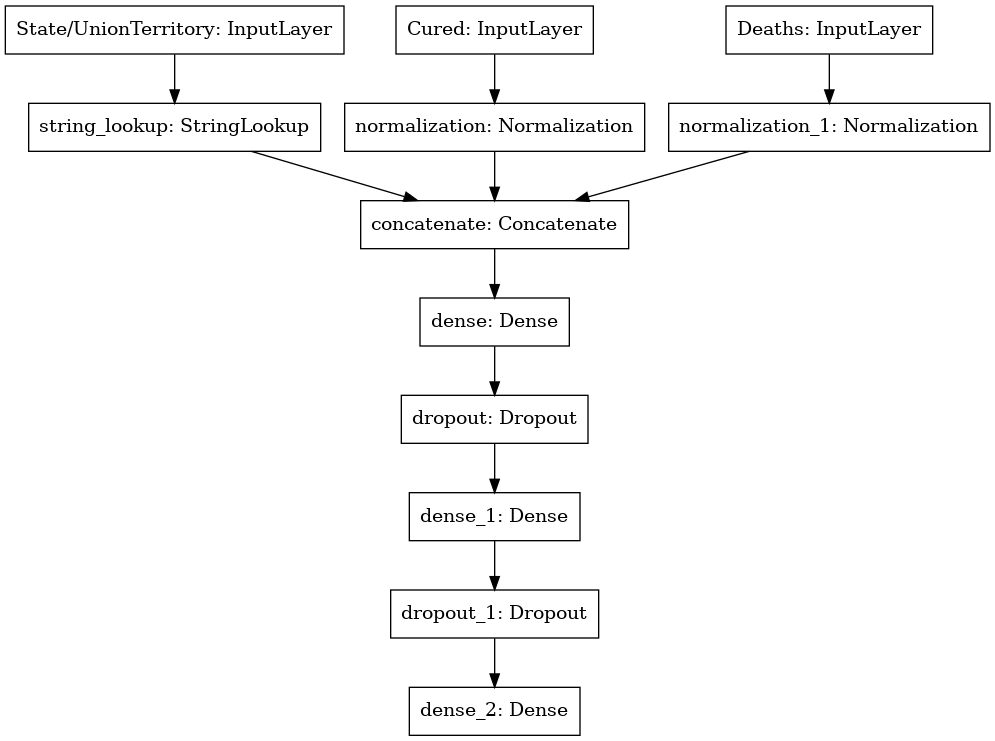

In [21]:
tf.keras.utils.plot_model(nn_model)

In [22]:
# Just the GBM
gbm = tfdf.keras.GradientBoostedTreesModel(
    num_trees = 100,
    max_depth = 20,
    task = tfdf.keras.Task.REGRESSION,
)

In [23]:
# To reduce the risk of mistakes, group both the decision forest and the
# neural network in a single keras model.
nn_without_head = tf.keras.models.Model(inputs = nn_model.inputs, outputs = last_layer)
gbm_and_nn_model = tfdf.keras.GradientBoostedTreesModel(
    num_trees = 100,
    max_depth = 20,
    preprocessing = nn_without_head,
    task = tfdf.keras.Task.REGRESSION,
)

In [24]:
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss",
    min_delta = 0.001,
    patience = 5,
    mode = "min"
)

In [25]:
nn_model.compile(
  optimizer = tf.keras.optimizers.Adam(lr = 0.0005),
  loss = "mse",
  metrics = ["mae", "mse", "mape"],
)

In [26]:
%%time
nn_model.fit(
    x = train_ds, 
    validation_data = val_ds, 
    epochs = 500,
    batch_size = 32,
    callbacks = [es_callback],
    verbose = 0
)

CPU times: user 5min 6s, sys: 25.3 s, total: 5min 32s
Wall time: 5min 19s


In [27]:
nn_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
State/UnionTerritory (InputLaye [(None, 1)]          0                                            
__________________________________________________________________________________________________
Cured (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
Deaths (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
string_lookup (StringLookup)    (None, 43)           0           State/UnionTerritory[0][0]       
______________________________________________________________________________________________

In [28]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label = "Training loss")
    plt.plot(epochs, val_loss, "r", label = "Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

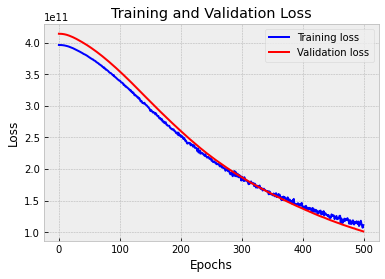

In [29]:
visualize_loss(nn_model.history, "Training and Validation Loss")

In [30]:
%%time
# Train a GBM 
gbm.compile(metrics = ["rmse"])
gbm.fit(x = train_ds)

212/212 [==============================] - 7s 1ms/step
CPU times: user 30.2 s, sys: 13.1 s, total: 43.3 s
Wall time: 31.4 s


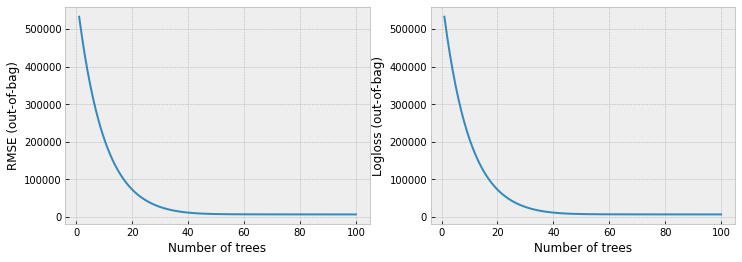

In [31]:
logs = gbm.make_inspector().training_logs()

plt.figure(figsize = (12, 4))
plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")
plt.show()

In [32]:
with open("./plot_model.html", 'w') as f:
    f.write(tfdf.model_plotter.plot_model(gbm))
    
IFrame("./plot_model.html", width = 900, height = 700)

In [33]:
%%time
# Train a GBM with NN output
gbm_and_nn_model.compile(metrics = ["mae", "mse", "mape"])
gbm_and_nn_model.fit(x = train_ds)

212/212 [==============================] - 1s 2ms/step
CPU times: user 6.71 s, sys: 3.32 s, total: 10 s
Wall time: 6.88 s


In [34]:
print(f"{b_}Evaluation:{r_}", nn_model.evaluate(test_ds))

18/18 [==============================] - 0s 2ms/step - loss: 771024814080.0000 - mae: 267691.4375 - mse: 771024814080.0000 - mape: 13.0184
Evaluation: [771024814080.0, 267691.4375, 771024814080.0, 13.018360137939453]


In [35]:
print(f"{b_}Evaluation:{r_}", gbm_and_nn_model.evaluate(test_ds))

18/18 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mae: 203976.7344 - mse: 388090298368.0000 - mape: 21.5561
Evaluation: [0.0, 203976.734375, 388090298368.0, 21.55608367919922]


<h1 style="color:blue">TabNet</h1>

- https://www.kaggle.com/carlmcbrideellis/tabnet-a-very-simple-regression-example/data
- https://www.kaggle.com/datafan07/optiver-volatility-predictions-using-tabnet/data
- https://www.kaggle.com/rapela/tps-02-21-tabnet-regressor
- https://github.com/dreamquark-ai/tabnet 

![tabnet](https://i.imgur.com/lYbF5d4.png)

In [36]:
### Torch Ecosystem ###
import torch
from pytorch_tabnet.metrics import Metric
from pytorch_tabnet.tab_model import TabNetRegressor

In [37]:
seed = 42

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
set_seed(seed)

In [38]:
X = train.drop(["Date", "Time", "State/UnionTerritory", "ConfirmedIndianNational", "ConfirmedForeignNational", "Confirmed"],
                    axis = 1)
y = train["Confirmed"]

X_test = test.drop(["Date", "Time", "State/UnionTerritory", "ConfirmedIndianNational", "ConfirmedForeignNational", "Confirmed"],
                  axis = 1)
y_test = test["Confirmed"]

In [39]:
print(f"{b_}X_train.shape: {r_}{X.shape}")
print(f"{b_}X_test.shape: {r_}{X_test.shape}")

X_train.shape: (16958, 3)
X_test.shape: (1152, 3)


In [52]:
X = X.to_numpy()
y = y.to_numpy().reshape(-1, 1)
X_test = X_test.to_numpy()

In [53]:
tabnet_params = dict(
    n_d = 16,
    n_a = 16,
    n_steps = 2,
    gamma = 1.3,
    lambda_sparse = 0,
    n_independent = 2,
    n_shared = 2,
    optimizer_fn = torch.optim.Adam,
    optimizer_params = dict(lr = 2e-2, weight_decay = 1e-5),
    mask_type = "entmax",
    scheduler_params = dict(
        mode = "min",
        patience = 5,
        min_lr = 1e-5,
        factor = 0.9
    ),
    scheduler_fn = torch.optim.lr_scheduler.ReduceLROnPlateau,
    seed = seed,
    device_name = "cuda",
    verbose = 10
)

In [54]:
kf = KFold(n_splits = 5, random_state = 42, shuffle = True)

predictions_array = []
CV_score_array = []

for train_index, test_index in kf.split(X):
    X_train, X_valid = X[train_index], X[test_index]
    y_train, y_valid = y[train_index], y[test_index]
    reg = TabNetRegressor(**tabnet_params)
    print(b_,"Begining of the Fold", "\n", g_, '*' * 45, c_)
    reg.fit(
        X_train = X_train,
        y_train = y_train,
        eval_set = [(X_valid, y_valid)],
        patience = 50,
        max_epochs = 200,
        batch_size = 1024,
        virtual_batch_size = 32,
        num_workers = 4,
        drop_last = False,
        eval_metric = ["rmse"]
    )
    print(y_, '=' * 45, m_)
    CV_score_array.append(reg.best_cost)
    #preds_test = reg.predict(X_test)
    #predictions_array.append(1 / (1 + np.exp(-preds_test)))
    predictions_array.append(reg.predict(X_test))

predictions = np.mean(predictions_array, axis = 0)

Device used : cuda
 Begining of the Fold 
  ********************************************* 
epoch 0  | loss: 415195995707.103| val_0_rmse: 582397.24474|  0:00:04s
epoch 10 | loss: 414324865282.1513| val_0_rmse: 581653.34255|  0:00:46s
epoch 20 | loss: 412191287884.46405| val_0_rmse: 579962.08717|  0:01:28s
epoch 30 | loss: 408854386126.10583| val_0_rmse: 577366.31792|  0:02:11s
epoch 40 | loss: 404354793201.46954| val_0_rmse: 573963.97266|  0:02:54s
epoch 50 | loss: 398908980363.9451| val_0_rmse: 569399.5959|  0:03:38s
epoch 60 | loss: 392474698115.6798| val_0_rmse: 564322.83385|  0:04:21s
epoch 70 | loss: 384321936667.6644| val_0_rmse: 557554.88414|  0:05:04s
epoch 80 | loss: 374861311233.6984| val_0_rmse: 550152.07767|  0:05:46s
epoch 90 | loss: 363907705033.99207| val_0_rmse: 541448.12108|  0:06:28s
epoch 100| loss: 352663826296.1309| val_0_rmse: 529838.57035|  0:07:11s
epoch 110| loss: 339584324572.5231| val_0_rmse: 521557.10769|  0:07:53s
epoch 120| loss: 326076869073.2761| val_0_r

In [56]:
print(f"{b_}The CV score is %.5f{r_}" % np.mean(CV_score_array, axis = 0) )

The CV score is 427251.17293


<h1 style="color:blue">XBNet</h1>
https://www.kaggle.com/mpwolke/xbnet-creditability

In [40]:
from XBNet.run import run_XBNET
from XBNet.models import XBNETRegressor
from XBNet.training_utils import training, predict

In [41]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.10, random_state = 42, shuffle = False)

In [42]:
X_train.shape, X_valid.shape

((15262, 3), (1696, 3))

In [43]:
y_train.shape, y_valid.shape

((15262,), (1696,))

In [47]:
model = XBNETRegressor(
    X_train,
    y_train,
    num_layers = 2
)

Enter dimensions of linear layers: 


Enter input dimensions of layer 1:  10
Enter output dimensions of layer 1:  10
Set bias as True or False:  True
Enter input dimensions of layer 2:  10
Enter output dimensions of layer 2:  1
Set bias as True or False:  False


Enter your last layer 


1. Sigmoid 
2. Softmax 
3. None 
 3


In [48]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [49]:
X_train, X_valid = X_train.to_numpy(), X_valid.to_numpy()
y_train, y_valid = y_train.to_numpy(), y_valid.to_numpy()

Training Loss after epoch 1 is 2002152290.2093847 and Accuracy is 98.83396345245869
Validation Loss after epoch 1 is 40241229824.0 and Accuracy is 97.05797849600668
Training Loss after epoch 2 is 1641861066.2118752 and Accuracy is 98.5708773070731
Validation Loss after epoch 2 is 47316488192.0 and Accuracy is 96.53769384622889
Training Loss after epoch 3 is 1631433159.5884104 and Accuracy is 98.59776702400484
Validation Loss after epoch 3 is 46608113664.0 and Accuracy is 96.58982368365672
Training Loss after epoch 4 is 1684663104.6072748 and Accuracy is 98.62107705725258
Validation Loss after epoch 4 is 45990039552.0 and Accuracy is 96.63530427198374
Training Loss after epoch 5 is 1721685179.3255522 and Accuracy is 98.63974090017517
Validation Loss after epoch 5 is 45491904512.0 and Accuracy is 96.6719581084758
Training Loss after epoch 6 is 1748971312.4748929 and Accuracy is 98.65589613497863
Validation Loss after epoch 6 is 45058580480.0 and Accuracy is 96.70384198805822
Training Los

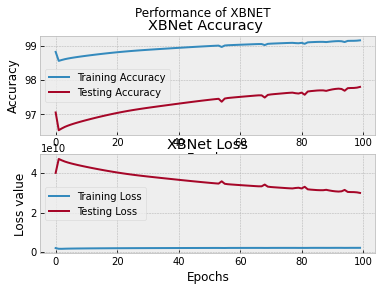

In [50]:
m, acc, lo, val_ac, val_lo = run_XBNET(
    X_train,
    X_valid,
    y_train,
    y_valid,
    model,
    criterion,
    optimizer,
    epochs = 100,
    batch_size = 128
)

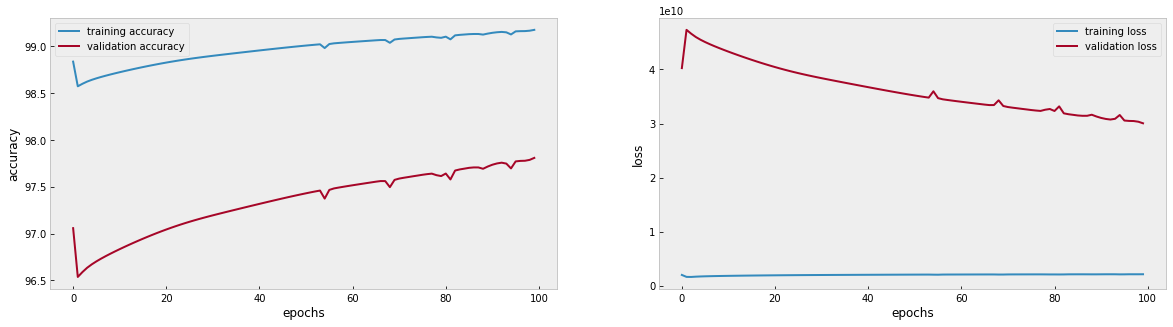

In [51]:
import matplotlib.pyplot as plt
plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
plt.plot(acc,label='training accuracy')
plt.plot(val_ac,label = 'validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.grid()
plt.subplot(1,2,2)
plt.plot(lo,label='training loss')
plt.plot(val_lo,label = 'validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend() 
plt.grid()

<h1 style="color:blue">Visualization of Test Data VS Predicted Data</h1>


In [57]:
xbnet_preds = []
for i in range(0, len(y_test)):
    xbnet_preds.append(predict(m, X_test[i, :]))

In [58]:
nn_preds = nn_model.predict(test_ds)
gbm_preds = gbm.predict(test_ds)
gbm_nn_preds = gbm_and_nn_model.predict(test_ds)

y_true = test["Confirmed"]

In [59]:
mse1 = mean_squared_error(y_true, nn_preds)
mse2 = mean_squared_error(y_true, gbm_preds)
mse3 = mean_squared_error(y_true, gbm_nn_preds)
mse4 = mean_squared_error(y_true, predictions)
mse5 = mean_squared_error(y_true, xbnet_preds)

print(f"{b_}MSE (nn): {r_}{mse1:.4f}")
print(f"{b_}MSE (GBM): {r_}{mse2:.4f}")
print(f"{b_}MSE (GBM + NN): {r_}{mse3:.4f}")
print(f"{b_}MSE (TabNet): {r_}{mse4:.4f}")
print(f"{b_}MSE (XBNet): {r_}{mse5:.4f}")

MSE (nn): 771024767173.0576
MSE (GBM): 3826250524.8762
MSE (GBM + NN): 388090253383.3394
MSE (TabNet): 1108390480069.0623
MSE (XBNet): 44903458386.6477


In [60]:
prom = np.mean([xbnet_preds, gbm_preds.reshape(-1)], axis = 0)
prom

array([   8595.883, 2064146.8  ,   40942.68 , ...,  372502.94 ,
       1888710.5  , 1678900.2  ], dtype=float32)

In [61]:
test["nn_preds"] = nn_preds
test["gbm_preds"] = gbm_preds
test["gbm_nn_preds"] = gbm_nn_preds
test["tabnet_preds"] = predictions
test["xbnet_preds"] = xbnet_preds
test["prom"] = prom

df_new = pd.concat([train, test], sort = False)

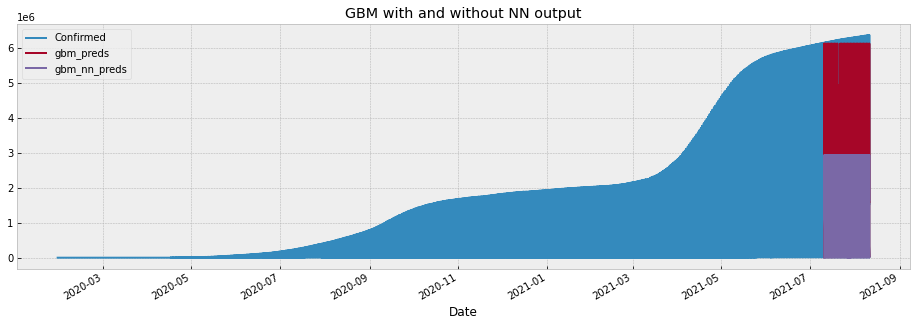

In [63]:
df_new[["Confirmed", "gbm_preds", "gbm_nn_preds"]].plot(figsize = (16, 5), title = "GBM with and without NN output");

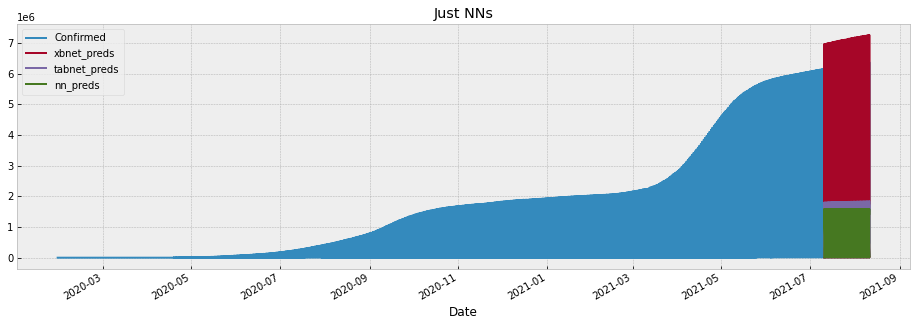

In [64]:
df_new[["Confirmed","xbnet_preds", "tabnet_preds", "nn_preds"]].plot(figsize = (16, 5), title = "Just NNs");

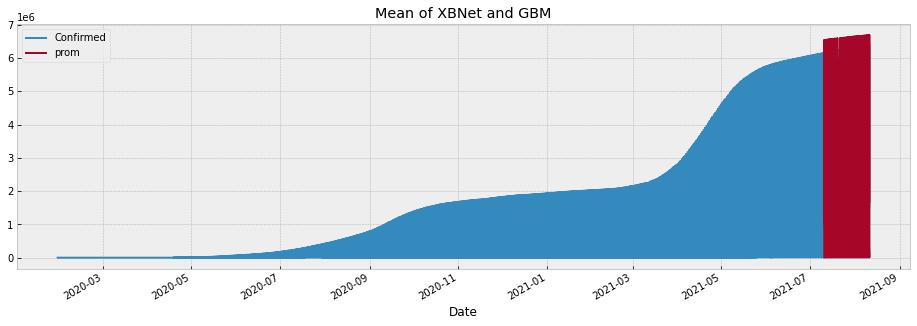

In [65]:
df_new[["Confirmed", "prom"]].plot(figsize = (16, 5), title = "Mean of XBNet and GBM");

- https://www.tensorflow.org/decision_forests/tutorials/beginner_colab
- https://www.tensorflow.org/decision_forests/tutorials/intermediate_colab
- https://www.tensorflow.org/decision_forests/tutorials/advanced_colab
- https://www.kaggle.com/kirankunapuli/tensorflow-decision-forests-on-diabetes-dataset
- https://www.kaggle.com/msafi04/tensorflow-decision-forests-stroke-prediction
- https://www.kaggle.com/pourchot/decision-forest-fed-by-neural-network
- https://www.kaggle.com/carlmcbrideellis/classification-using-tensorflow-decision-forests/data
- https://www.kaggle.com/rohan4050/algorithmic-trading-stock-price-model